## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для нас как для специалистов в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
from sklearn import (cluster, ensemble, feature_selection, linear_model,
                     metrics, model_selection, preprocessing, tree)

Прочитаем наш файл с исходными данными:

In [7]:
taxi_data = pd.read_csv("/kaggle/input/nyc-taxi/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки на нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [8]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print('От', taxi_data['pickup_datetime'].dt.date.min(), 'до', taxi_data['pickup_datetime'].dt.date.max())

От 2016-01-01 до 2016-06-30


Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [9]:
print('Суммарное количество пропусков в данных:', taxi_data.isnull().sum().sum())

Суммарное количество пропусков в данных: 0


Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведем в секундах и округлим до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [10]:
print('Количество таксопарков в данных:', taxi_data['vendor_id'].nunique(),'.')
print('Максимальное количество пассажиров:', taxi_data['passenger_count'].max(),'.')
print('Средняя продолжительность поездки', round(taxi_data['trip_duration'].mean()), 'секунд.')
print('Медианная продолжительность поездки', round(taxi_data['trip_duration'].median()), 'секунд.')
print('Минимальное время поездки', round(taxi_data['trip_duration'].min()), 'секунд.')
print('Максимальное время поездки', round(taxi_data['trip_duration'].max()), 'секунд.')

Количество таксопарков в данных: 2 .
Максимальное количество пассажиров: 9 .
Средняя продолжительность поездки 959 секунд.
Медианная продолжительность поездки 662 секунд.
Минимальное время поездки 1 секунд.
Максимальное время поездки 3526282 секунд.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлим до целого.

In [11]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week_num'] = df['pickup_datetime'].dt.day_of_week
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

add_datetime_features(taxi_data)

print('По субботам было совершено', taxi_data['id'][taxi_data['pickup_day_of_week']=='Saturday'].count(), 'поездок.')
print('В среднем в день совершается', round(taxi_data['id'].count() / taxi_data['pickup_date'].nunique()), 'поездок.')

По субботам было совершено 220868 поездок.
В среднем в день совершается 8015 поездок.


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведем в секундах, округлив до целого.


In [12]:
holiday_data = pd.read_csv('/kaggle/input/project-5-regression1/holiday_data.csv', sep=';')

def add_holiday_features(df, holiday_df):
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date
    df = df.merge(holiday_data, how='left', left_on='pickup_date', right_on='date')
    df['pickup_holiday'] = df['holiday'].fillna(0)
    df['pickup_holiday'] = df['pickup_holiday'].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(['day', 'date', 'holiday'], axis=1)
    return df

taxi_data = add_holiday_features(taxi_data, holiday_data)

print('Медианная длительность поездки на такси в праздничные дни', 
      round(taxi_data['trip_duration'][taxi_data['pickup_holiday']==1].median()), 'секунд.')

Медианная длительность поездки на такси в праздничные дни 585 секунд.


Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [13]:
osrm_data = pd.read_csv('/kaggle/input/osrmdatatrain/osrm_data_train.csv')

def add_osrm_features(df, OSMR):
    df = df.merge(OSMR[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], 
                  how='left', left_on='id', right_on='id')
    return df

taxi_data = add_osrm_features(taxi_data, osrm_data)

print('Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM', 
      round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()), 'секунды.')
print('После объединения таблиц в столбцах с информацией из OSRM API содержится', 
     taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum().sum(), 'пропуска.')

Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM 372 секунды.
После объединения таблиц в столбцах с информацией из OSRM API содержится 3 пропуска.


In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлим до сотых.


In [15]:
def add_geographical_features(df):
    lat1 = np.array(df['pickup_latitude'])
    lng1 = np.array(df['pickup_longitude'])
    lat2 = np.array(df['dropoff_latitude'])
    lng2 = np.array(df['dropoff_longitude'])
    df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return df

taxi_data = add_geographical_features(taxi_data)

print('Медианное расстояние Хаверсина поездок равно', round(taxi_data['haversine_distance'].median(), 2), 'километров.')

Медианное расстояние Хаверсина поездок равно 2.09 километров.


Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [16]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42) #  n_init=10,
kmeans.fit(coords)

def add_cluster_features(df, alg_klust):
    # предскажем, к каким кластерам принадлежат точки и запишем в столбец
    df['geo_cluster'] = alg_klust.predict(np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                                                     df[['dropoff_latitude', 'dropoff_longitude']])))
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)

print('В наименьшем по размеру географическом кластере содержится', 
      taxi_data['geo_cluster'].value_counts().min(), 'поездки.')

В наименьшем по размеру географическом кластере содержится 2 поездки.


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у нас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведем с точностью до сотых процента.


In [17]:
weather_data = pd.read_csv('/kaggle/input/weatherdata/weather_data.csv')

def add_weather_features(df1, df2):
    df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%d %H')
    df2['date'] = df2['time'].dt.date
    df2['hour'] = df2['time'].dt.hour
    df2 = df2.drop(['time', 'windchill', 'heat index', 'humidity', 'pressure',
                   'dew Point', 'wind dir', 'gust speed', 'conditions'], axis=1)
    df1 = df1.merge(df2, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    return df1

taxi_data = add_weather_features(taxi_data, weather_data)

print('В снежную погоду было совершено', 
      taxi_data['id'][taxi_data['events']=='Snow'].nunique(), 'поездок.')
print('Отношение общего количества наблюдений к пропускам в столбцах с погодными условиями', 
      round(taxi_data['temperature'].isnull().sum() / taxi_data.shape[0] * 100, 2), 'процентов.')

В снежную погоду было совершено 13126 поездок.
Отношение общего количества наблюдений к пропускам в столбцах с погодными условиями 0.82 процентов.


Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлим до десятых.


In [18]:
def fill_null_weather_data(df):
    df['temperature'] = df['temperature'].fillna(df.groupby('pickup_date')['temperature'].transform('median'))
    df['visibility'] = df['visibility'].fillna(df.groupby('pickup_date')['visibility'].transform('median'))
    df['wind speed'] = df['wind speed'].fillna(df.groupby('pickup_date')['wind speed'].transform('median'))
    df['precip'] = df['precip'].fillna(df.groupby('pickup_date')['precip'].transform('median'))
    df['events'] = df['events'].fillna('None')
    df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
    df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
    df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())
    return df

taxi_data = fill_null_weather_data(taxi_data)

print('Медиана в столбце temperature после заполнения пропусков равна', 
      round(taxi_data['temperature'].median(), 1), 'градусов.')

Медиана в столбце temperature после заполнения пропусков равна 11.1 градусов.


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


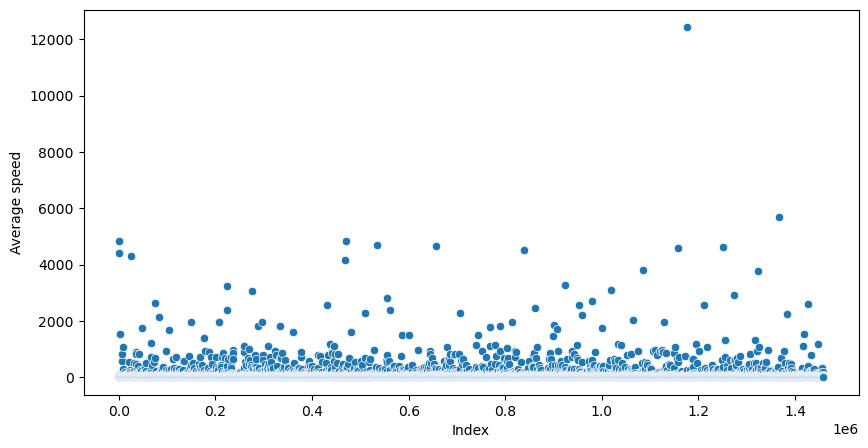

In [19]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

а) Сколько выбросов по признаку длительности поездки нам удалось найти?

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

б) Сколько выбросов по признаку скорости нам удалось найти?

In [20]:
print('Количество выбросов по длительности поездки:', taxi_data[taxi_data['trip_duration']>(24 * 3600)].shape[0])
print('Количество выбросов по скорости поездки:', taxi_data[avg_speed>300].shape[0])

Количество выбросов по длительности поездки: 4
Количество выбросов по скорости поездки: 407


In [21]:
taxi_data = taxi_data.loc[taxi_data['trip_duration'] <= (24 * 3600)]
taxi_data = taxi_data[avg_speed <= 300]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [22]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным? 
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлим до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

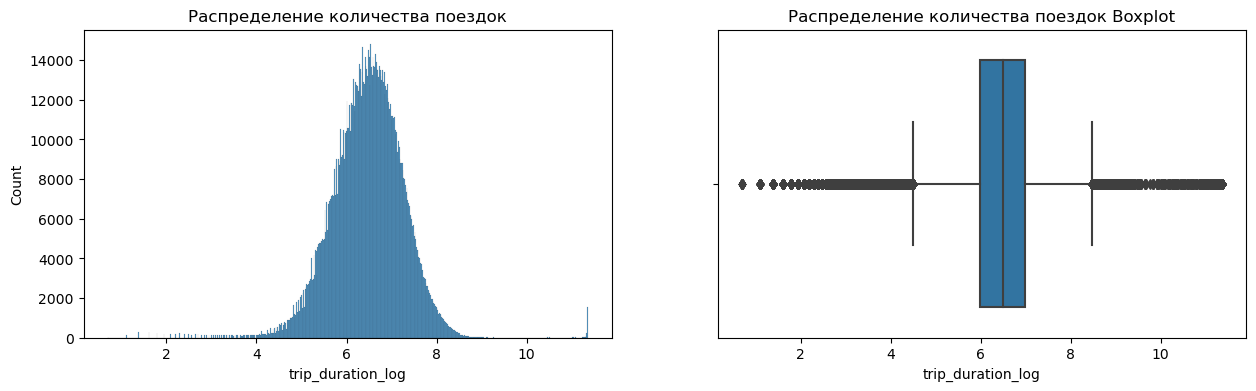

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=axes[0]);
histplot.set_title('Распределение количества поездок');
boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', ax=axes[1]);
boxplot.set_title('Распределение количества поездок Boxplot');

In [24]:
from scipy.stats import normaltest

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

_, p = normaltest(taxi_data['trip_duration_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.2f' % p)
print(p)             # Нужно рассматривать все значения p.

# Интерпретация 

if p > alpha/2:
    print(H0)
else:
    print(Ha)

p=0.00
0.0
Данные не распределены нормально (мы отвергаем H0)


Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

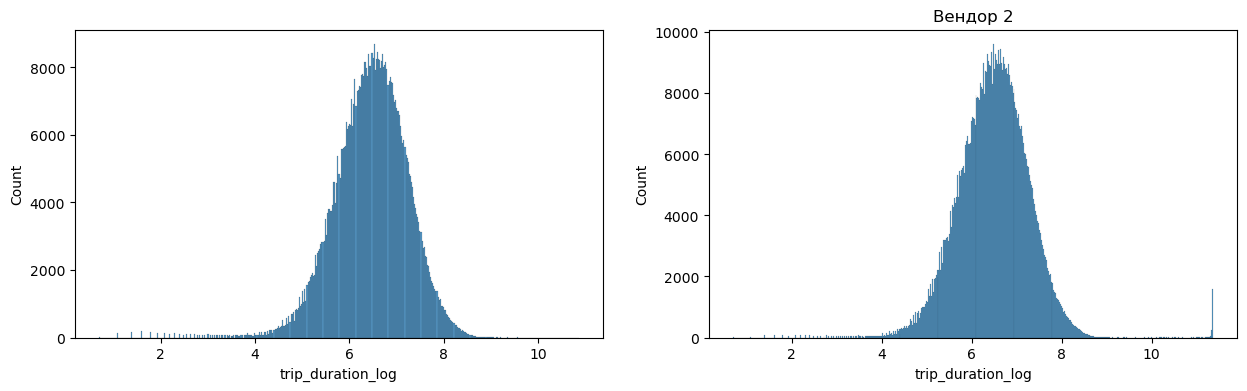

In [25]:
vendor_id_1 = taxi_data[taxi_data['vendor_id']==1]['trip_duration_log']
vendor_id_2 = taxi_data[taxi_data['vendor_id']==2]['trip_duration_log']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=vendor_id_1, ax=axes[0]);
histplot.set_title('Вендор 1');
histplot2 = sns.histplot(data=vendor_id_2, ax=axes[1]);
histplot2.set_title('Вендор 2');

**Вывод:**: Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

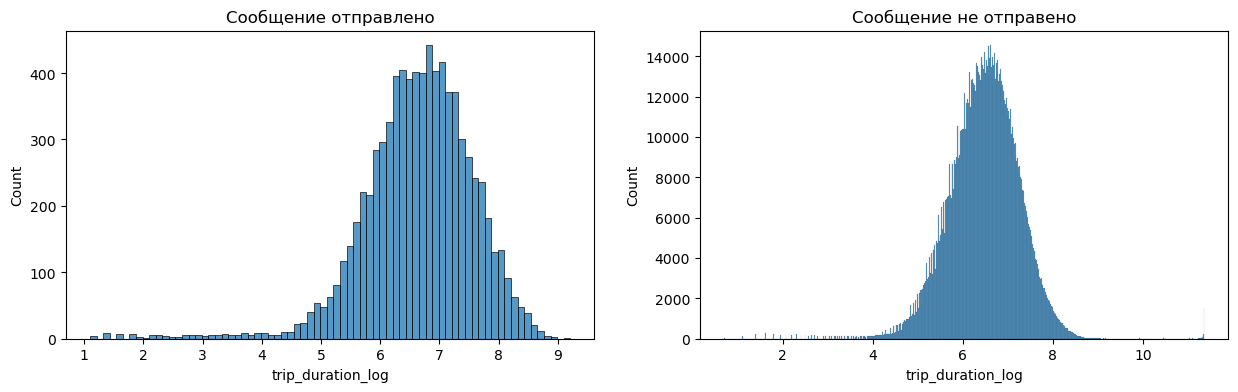

In [26]:
store_and_fwd_flag_Y = taxi_data[taxi_data['store_and_fwd_flag']=='Y']['trip_duration_log']
store_and_fwd_flag_N = taxi_data[taxi_data['store_and_fwd_flag']=='N']['trip_duration_log']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=store_and_fwd_flag_Y, ax=axes[0]);
histplot1.set_title('Сообщение отправлено');
histplot2 = sns.histplot(data=store_and_fwd_flag_N, ax=axes[1]);
histplot2.set_title('Сообщение не отправено');

**Вывод:**: Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответим на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

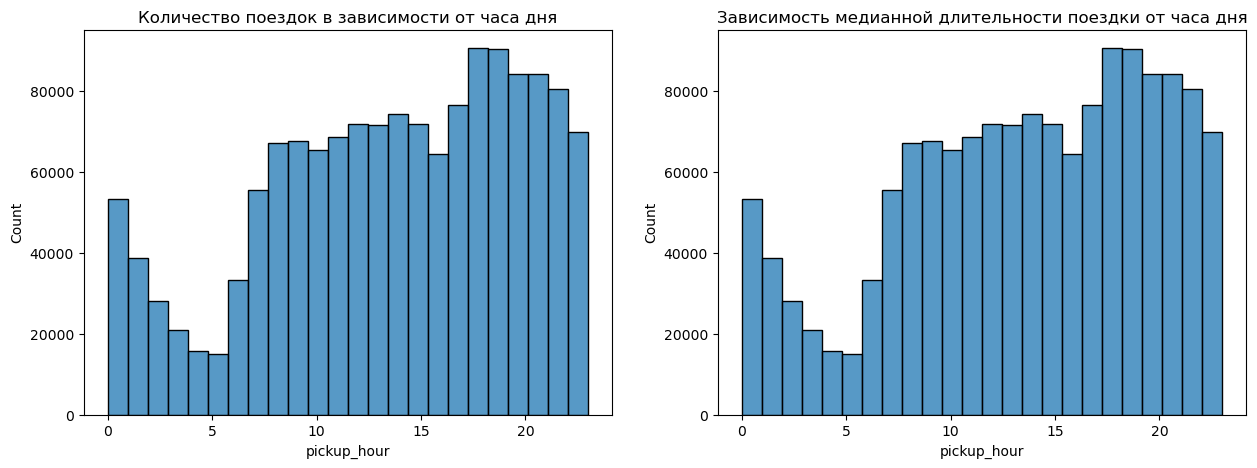

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

histplot1 = sns.histplot(x=taxi_data['pickup_hour'], 
                         label=taxi_data['pickup_hour'].value_counts(), 
                         bins = 24, 
                         ax=axes[0]);
histplot1.set_title('Количество поездок в зависимости от часа дня');

histplot2 = sns.histplot(x=taxi_data['pickup_hour'], 
                         label=taxi_data.groupby(by = 'pickup_hour')['trip_duration'].median(), 
                         bins = 24, 
                         ax=axes[1]);
histplot2.set_title('Зависимость медианной длительности поездки от часа дня');

Реже всего такси заказывают до 5 утра, а пик медианной длительности поездок с 17 часов.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответим на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


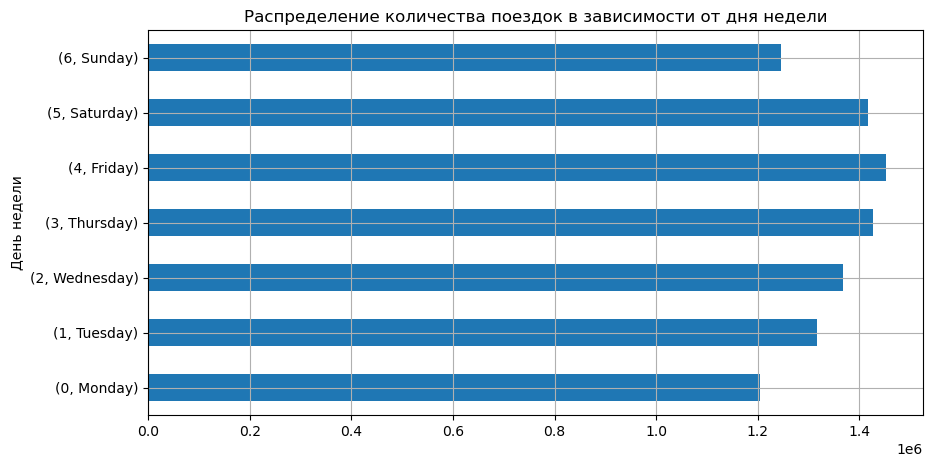

In [28]:
trip_duration_day_of_week = taxi_data.groupby(by=['pickup_day_of_week_num', 'pickup_day_of_week'])['trip_duration_log'].sum()

# Рисуем диаграмму, отображающую распределение количества поездок в зависимости от дня недели
trip_duration_day_of_week.plot(kind='barh', 
                               figsize=(10, 5), 
                               grid=True, 
                               title='Распределение количества поездок в зависимости от дня недели', 
                               xlabel='День недели'
                              );

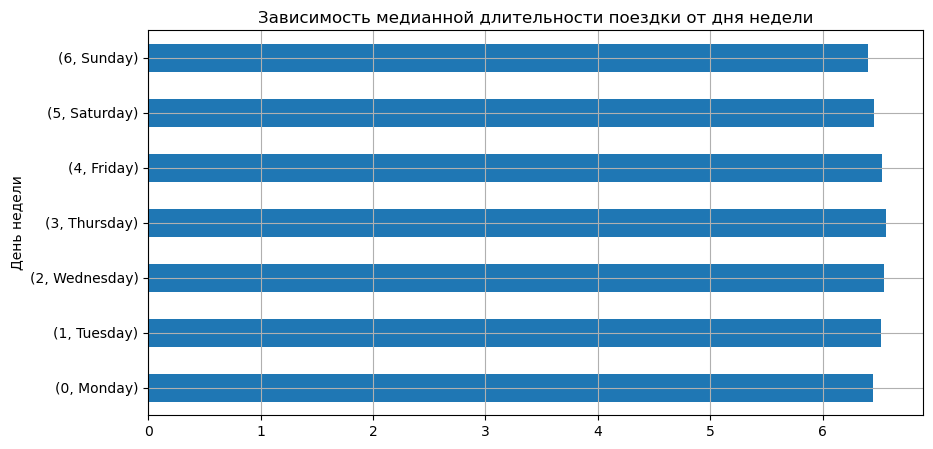

In [29]:
trip_duration_day_of_week_median = taxi_data.groupby(by=['pickup_day_of_week_num', 'pickup_day_of_week'])['trip_duration_log'].median()

# Рисуем диаграмму, отображающую зависимость медианной длительности поездки от дня недели
trip_duration_day_of_week_median.plot(kind='barh', 
                                      figsize=(10, 5), 
                                      grid=True, 
                                      title='Зависимость медианной длительности поездки от дня недели', 
                                      xlabel='День недели'
                                     );

Больше всего поездок совершается в пятницу, а наименьшая медианная длительность поездок в понедельник.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

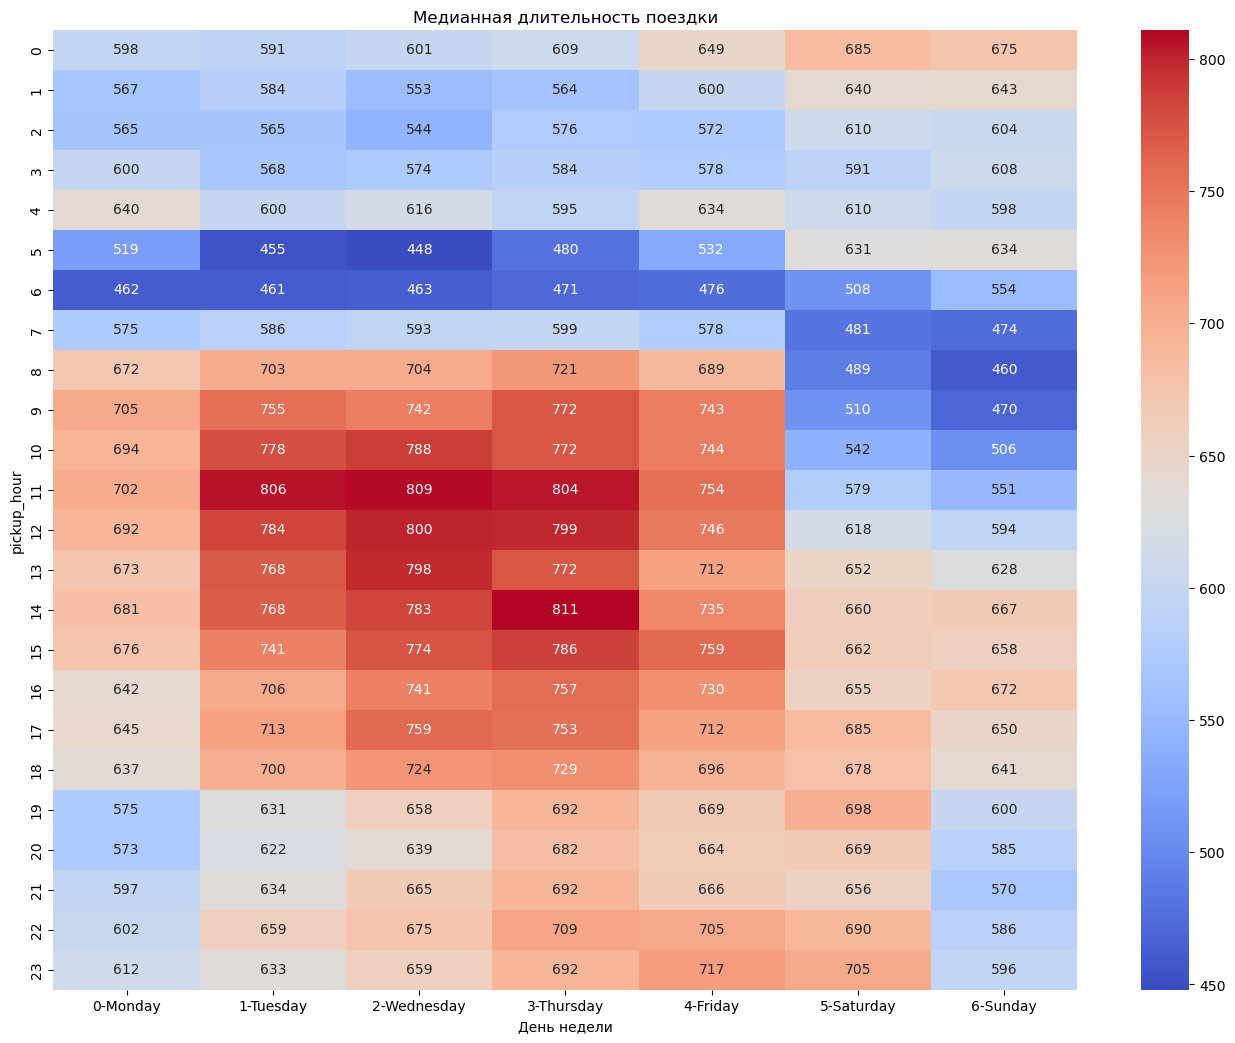

In [30]:
pivot_table = taxi_data.pivot_table(values='trip_duration',
                                    index='pickup_hour',
                                    columns=['pickup_day_of_week_num', 'pickup_day_of_week'],
                                    aggfunc='median',
                                    fill_value=0
                                   )

# Рисуем диаграмму, отображающую сводную таблицу медианной длительности поездок по часам и дням недели
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
heatmap = sns.heatmap(data = pivot_table, annot=True, fmt='.0f', cmap='coolwarm')
# Добавим поясняющие подписи
heatmap.set_title('Медианная длительность поездки');
axes.set_xlabel('День недели');

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

Для наглядности уменьшим размер точек на диаграмме рассеяния.  


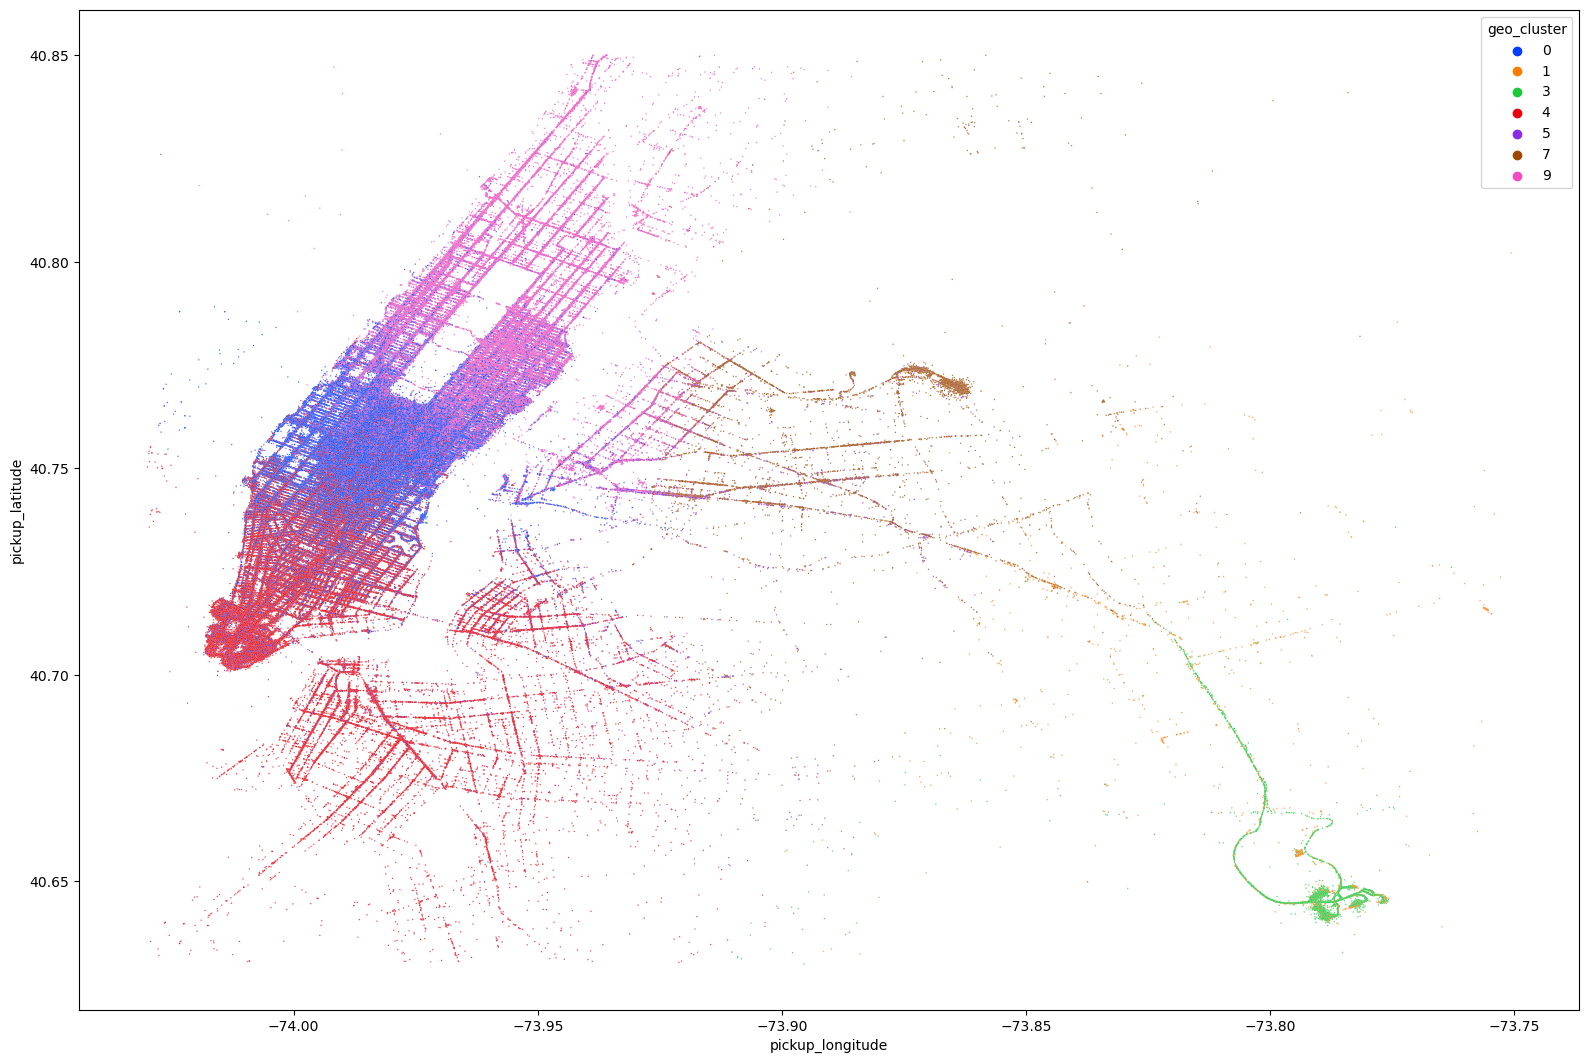

In [31]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

df_map = taxi_data[['pickup_latitude', 
                    'pickup_longitude', 
                    'dropoff_latitude', 
                    'dropoff_longitude', 
                    'geo_cluster']][(taxi_data['pickup_longitude'] >= city_long_border[0]) 
                                    & (taxi_data['pickup_longitude'] <= city_long_border[1])
                                    & (taxi_data['pickup_latitude'] >= city_lat_border[0]) 
                                    & (taxi_data['pickup_latitude'] <= city_lat_border[1])
                                    & (taxi_data['dropoff_longitude'] >= city_long_border[0])
                                    & (taxi_data['dropoff_longitude'] <= city_long_border[1])
                                    & (taxi_data['dropoff_latitude'] >= city_lat_border[0])
                                    & (taxi_data['dropoff_latitude'] <= city_lat_border[1])]

fig = plt.figure(figsize=(15, 10))
axes = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(
    data=df_map, 
    x='pickup_longitude', 
    y='pickup_latitude',
    hue='geo_cluster', 
    palette='bright',
    s=1, # размер точки
    alpha=.8,
);

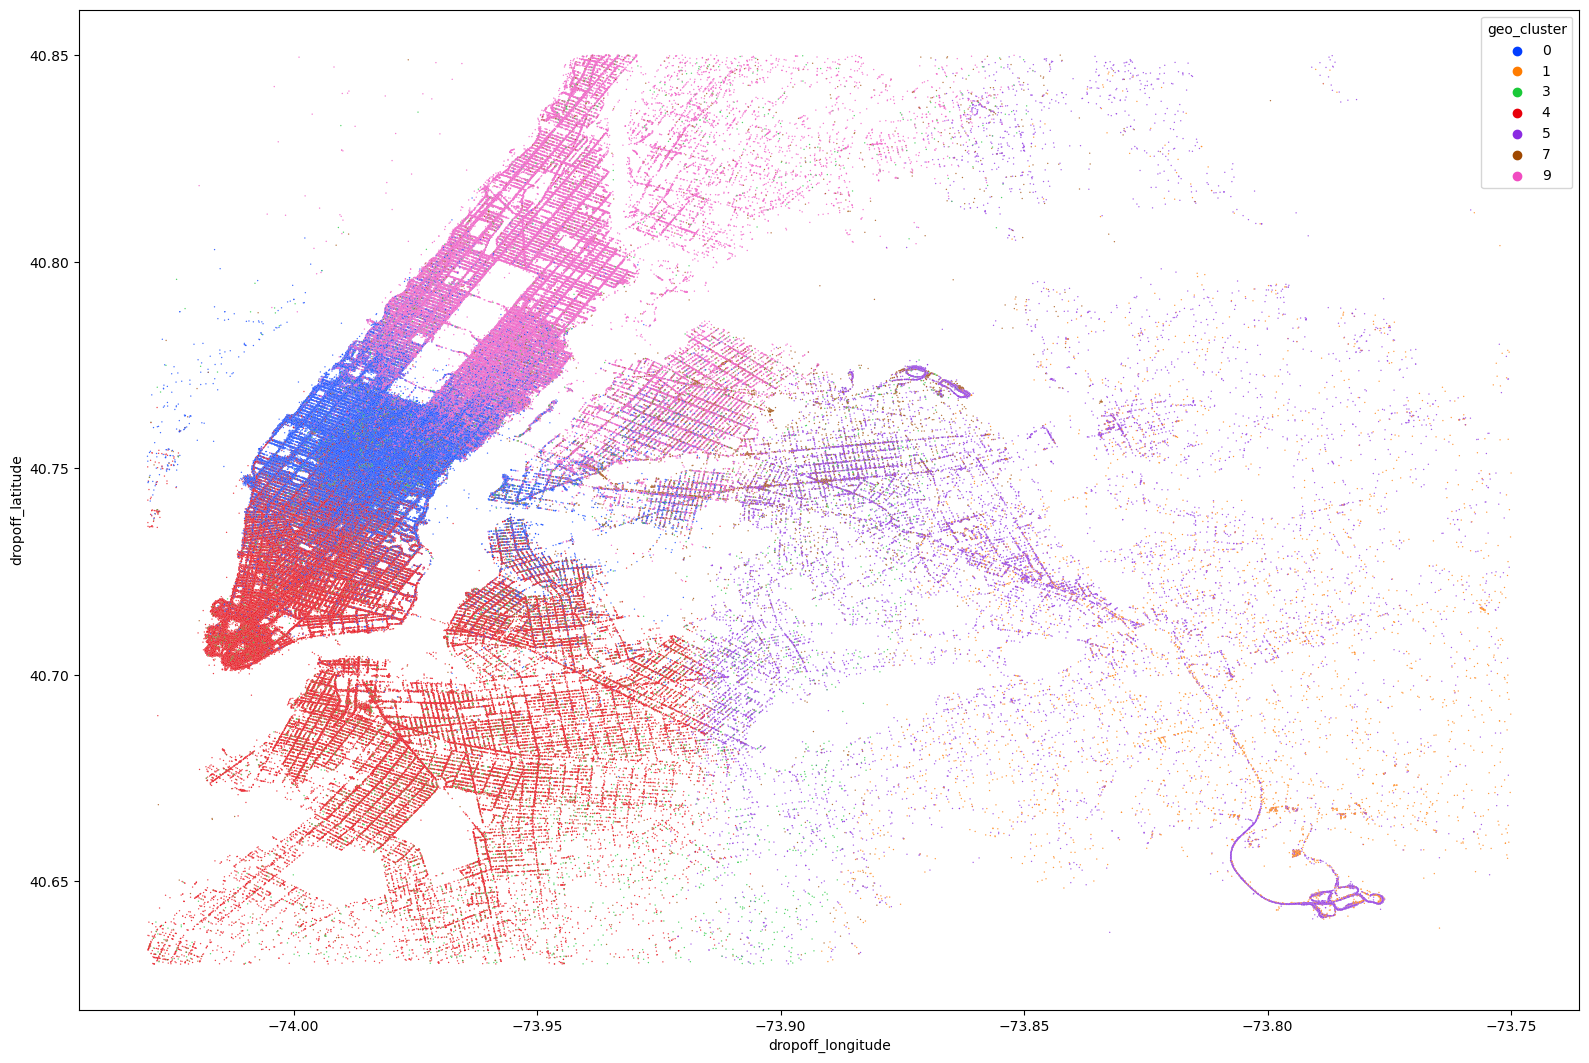

In [32]:
fig = plt.figure(figsize=(15, 10))
axes = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(
    data=df_map, 
    x='dropoff_longitude', 
    y='dropoff_latitude',
    hue='geo_cluster', 
    palette='bright',
    s=1, # размер точки
    alpha=.8,
);

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [33]:
taxi_data.drop(['date', 'hour', 'pickup_day_of_week_num'], axis=1, inplace=True)

In [34]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [35]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумаем, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключим выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у нас осталось?


a) **Ответ:** id. Уникальным для каждой поездки является её идентификатор — столбец id. Он никак не связан с длительностью поездки и не имеет значения при её прогнозировании.

б) **Ответ:** ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) **Ответ:** dropoff_datetime. В наших данных утечку создаёт признак dropoff_datetime — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

In [36]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
print('Осталось', train_data.shape[1], 'столбцов.')

Осталось 25 столбцов.


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [37]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитаем среднее по закодированному столбцу vendor_id. Ответ приведем с точностью до сотых.

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag. Ответ приведем с точностью до тысячных.



In [38]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)
print('Среднее по столбцу vendor_id:', round(train_data['vendor_id'].mean(), 2))
print('Среднее по столбцу store_and_fwd_flag:', round(train_data['store_and_fwd_flag'].mean(), 3))
print('Shape of data:  {}'.format(train_data.shape))

Среднее по столбцу vendor_id: 0.53
Среднее по столбцу store_and_fwd_flag: 0.006
Shape of data:  (1458233, 23)


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEncoder() из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

Сколько бинарных столбцов у нас получилось сгенерировать с помощью однократного кодирования?


In [39]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = preprocessing.OneHotEncoder(drop='first', sparse=False, categories='auto')
data_onehot = encoder.fit_transform(train_data[columns_to_change])

column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print('Получилось сгенерировать {} столбцов.'.format(data_onehot.shape[1]))

Получилось сгенерировать 18 столбцов.


Добавим полученную таблицу с закодированными признаками:

In [40]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [41]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [42]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Укажем признаки, которые вошли в список отобранных


In [43]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]
print(list(best_features))

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_Monday', 'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday', 'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday', 'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помним, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлим до сотых.


In [44]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print(round(X_valid_scaled.mean(), 2))

0.26


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [45]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train_log)

y_train_log_pred = lr.predict(X_train_scaled)
y_valid_log_pred = lr.predict(X_valid_scaled)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2))
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2))

RMSLE for train: 0.54
RMSLE for valid: 0.54


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Наблюдаются ли у нашей модели признаки переобучения?


In [46]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.fit_transform(X_valid_scaled)

lr = LinearRegression()
lr.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = lr.predict(X_train_scaled_poly)
y_valid_log_pred = lr.predict(X_valid_scaled_poly)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2)) # Ответ: 0.47.
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2)) # Ответ: 0.7.

RMSLE for train: 0.47
RMSLE for valid: 0.7


У модели наблюдаются признаки переобучения.

Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установим равным 1, остальные параметры оставим по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [47]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = ridge.predict(X_train_scaled_poly)
y_valid_log_pred = ridge.predict(X_valid_scaled_poly)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2)) # Ответ: 0.48.
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2)) # Ответ: 0.48.

RMSLE for train: 0.48
RMSLE for valid: 0.48


Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.

б) Наблюдаются ли у нашей модели признаки переобучения?


In [48]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train_scaled, y_train_log)
y_train_log_pred = dt.predict(X_train_scaled)
y_valid_log_pred = dt.predict(X_valid_scaled)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2))
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2))

RMSLE for train: 0.0
RMSLE for valid: 0.57


У модели наблюдаются признаки переобучения.

Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

        max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлим до сотых.


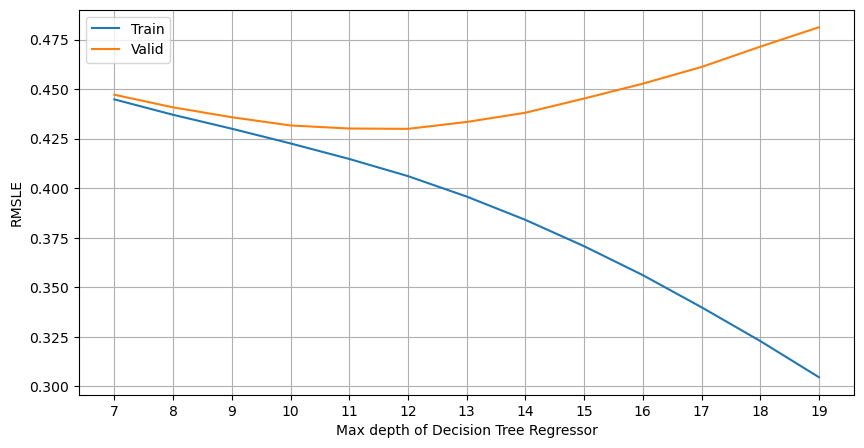

In [49]:
max_depths = range(7, 20)
train_scores = []
valid_scores = []

for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    dt.fit(X_train_scaled, y_train_log)
    y_train_log_pred = dt.predict(X_train_scaled)
    y_valid_log_pred = dt.predict(X_valid_scaled)
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)))

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=max_depths, y=train_scores, label='Train')
sns.lineplot(x=max_depths, y=valid_scores, label='Valid')
ax.set_xlabel('Max depth of Decision Tree Regressor')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depths)
ax.grid()

**Ответ:** max_depth=12.

In [50]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=12)
dt.fit(X_train_scaled, y_train_log)
y_train_log_pred = dt.predict(X_train_scaled)
y_valid_log_pred = dt.predict(X_valid_scaled)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2))
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2))

RMSLE for train: 0.41
RMSLE for valid: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

Построим модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [51]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train_log)
y_train_log_pred = rf.predict(X_train_scaled)
y_valid_log_pred = rf.predict(X_valid_scaled)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2))
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.8s finished


RMSLE for train: 0.4
RMSLE for valid: 0.41


Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. Ответ округлим до сотых.


In [52]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42,
    verbose=True,
)

gb.fit(X_train_scaled, y_train_log)
y_train_log_pred = gb.predict(X_train_scaled)
y_valid_log_pred = gb.predict(X_valid_scaled)

print('RMSLE for train:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)), 2))
print('RMSLE for valid:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)), 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           13.33m
         2           0.2247           13.15m
         3           0.1987           13.00m
         4           0.1875           12.84m
         5           0.1821           12.72m
         6           0.1789           12.58m
         7           0.1742           12.45m
         8           0.1721           12.29m
         9           0.1705           12.14m
        10           0.1694           12.00m
        20           0.1585           10.66m
        30           0.1532            9.29m
        40           0.1500            7.94m
        50           0.1468            6.61m
        60           0.1439            5.29m
        70           0.1421            3.96m
        80           0.1402            2.64m
        90           0.1383            1.32m
       100           0.1371            0.00s
RMSLE for train: 0.37
RMSLE for valid: 0.39


Какая из построенных нами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


**Ответ:** Градиентный бустинг над деревьями решений.

Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажем топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


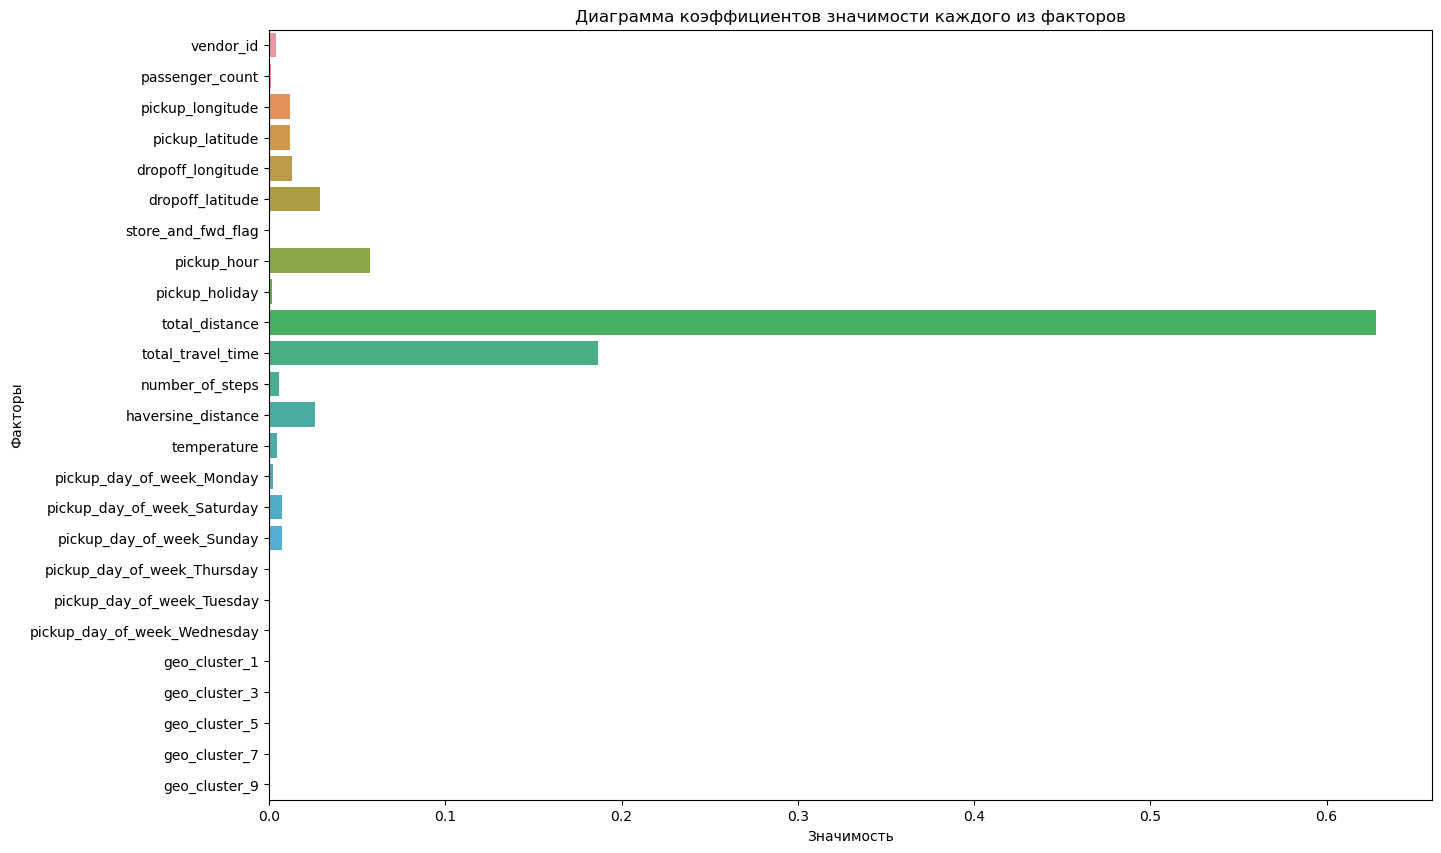

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))
feature = X.columns
feature_importances = gb.feature_importances_
sns.barplot(y=best_features, x=feature_importances, orient='h', ax=ax);
ax.set_title('Диаграмма коэффициентов значимости каждого из факторов')
ax.set_ylabel('Факторы')
ax.set_xlabel('Значимость');

Как видно из диаграммы 3 самых значимых признака это: total_distans, total_travel_time, pickup_hour.

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.


In [54]:
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(gb.predict(X_valid_scaled)) - 1

print('MeAE for valid:', round(metrics.median_absolute_error(y_valid_pred, y_valid)/60, 1))

MeAE for valid: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [55]:
test_data = pd.read_csv("/kaggle/input/ny-dataset/test.csv")
osrm_data_test = pd.read_csv("/kaggle/input/nyfastestroutes/fastest_routes_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [56]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change])#.toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как мы сформируем предсказание длительности поездок на тестовой выборке нам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [57]:
model = gb
y_test_predict = np.exp(model.predict(X_test_scaled)) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [58]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [59]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [60]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93569	valid-rmse:1.93564
[20]	train-rmse:0.78536	valid-rmse:0.78613
[30]	train-rmse:0.47928	valid-rmse:0.48116
[40]	train-rmse:0.42124	valid-rmse:0.42379
[50]	train-rmse:0.40926	valid-rmse:0.41229
[60]	train-rmse:0.40491	valid-rmse:0.40834
[70]	train-rmse:0.40176	valid-rmse:0.40558
[80]	train-rmse:0.39891	valid-rmse:0.40302
[90]	train-rmse:0.39741	valid-rmse:0.40182
[100]	train-rmse:0.39562	valid-rmse:0.40025
[110]	train-rmse:0.39395	valid-rmse:0.39898
[120]	train-rmse:0.39298	valid-rmse:0.39840
[130]	train-rmse:0.39208	valid-rmse:0.39777
[140]	train-rmse:0.39120	valid-rmse:0.39725
[150]	train-rmse:0.38932	valid-rmse:0.39572
[160]	train-rmse:0.38892	valid-rmse:0.39550
[170]	train-rmse:0.38792	valid-rmse:0.39473
[180]	train-rmse:0.38715	valid-rmse:0.39430
[190]	train-rmse:0.38660	valid-rmse:0.39409
[200]	train-rmse:0.38587	valid-rmse:0.39379
[210]	train-rmse:0.38500	valid-rmse:0.39331
[220]	train-rmse:0.38437	valid-rmse:0.39294

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [61]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39087


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

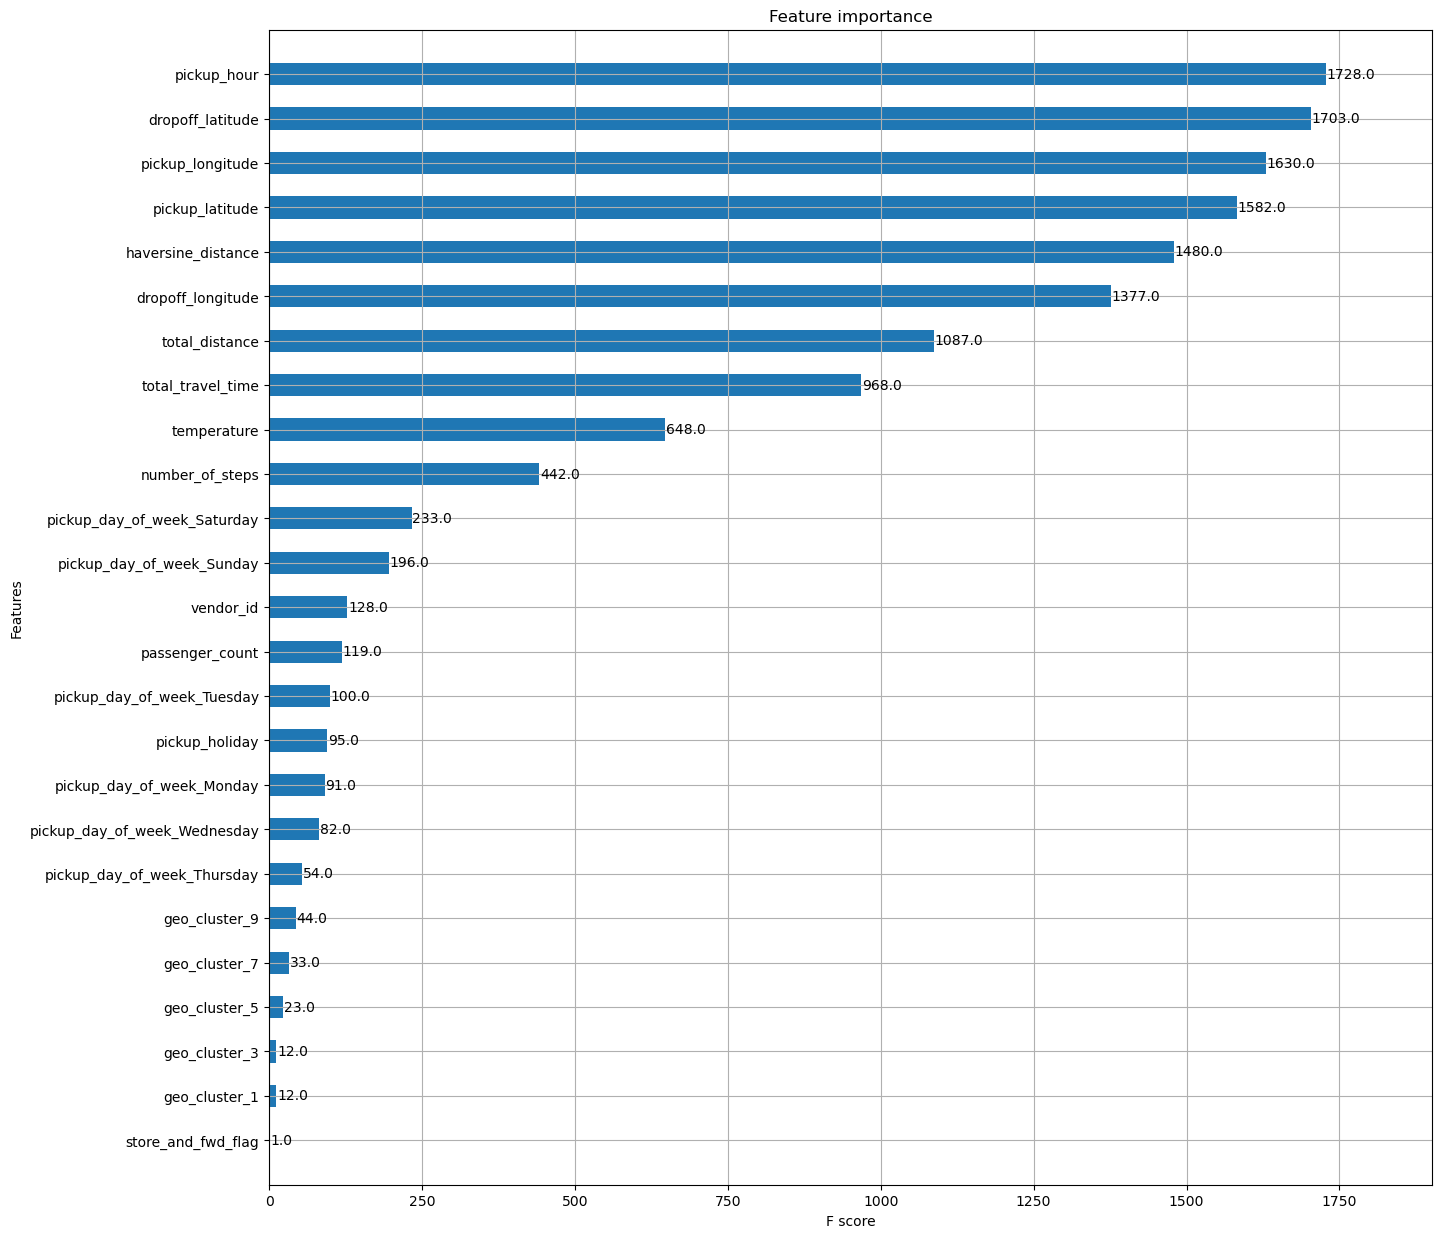

In [62]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)